In [73]:
import xarray as xr
import pymc as pymc
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
import arviz as az

from scipy.special import expit

from werp_projecting_sfis.file_io import sfi_file_to_pandas 


In [74]:
filename = r"C:/Users/rob635/OneDrive - CSIRO/WERP/SFI_Projection/Data/_MURR_B0D000__eFA_annual_stats_10discount.txt"
outdf = sfi_file_to_pandas(filename)

outdf

,BMF_R1,BMF_R2,BMF_R3,BMF_R4,BMF_R5,BMF_R6,BMF_R7,GKP_R1,GKP_R2,GKP_R3,...,EDW_R1,EDW_R2,EDW_R3,EDW_R4,EDW_R5,LDF_R1,LDF_R2,LDF_R3,LDF_R4,LDF_R5
1896-06-30,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1897-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1898-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1899-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1900-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2006-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2007-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
inflowfile = "C:/Users/rob635/OneDrive - CSIRO/WERP/SFI_Projection/Data/InflowData_from modelled outputs_P0H/MURR.csv"

inpredictor = pd.read_csv(inflowfile)
inpredictor['date'] = pd.to_datetime(inpredictor['date'])
inpredictor.set_index('date', inplace=True)
inpredictor
annualpredictor = inpredictor.resample("YE-JUN").sum()
annualpredictor

,inflow,outflow,local
date,,,
1896-06-30,8322251.0,3376607.0,5.651775e+06
1897-06-30,6021355.0,2139088.0,4.251536e+06
1898-06-30,8828884.0,1583839.0,5.022850e+06
1899-06-30,8595550.0,2523049.0,6.169939e+06
1900-06-30,8050405.0,2877384.0,5.119717e+06
...,...,...,...
2005-06-30,7253731.0,1711289.0,5.462452e+06
2006-06-30,8887863.0,2754732.0,6.492137e+06
2007-06-30,2910648.0,723644.0,2.152755e+06


In [76]:
laggedinflow_predictor = annualpredictor.copy(deep=True)
laggedtimeindex = laggedinflow_predictor.index
laggedtimeindexstring = [ str(laggedtime.year-1) + "-" + str(laggedtime.month) + "-" + str(laggedtime.day) for laggedtime in laggedtimeindex]
laggedinflow_predictor.index = pd.to_datetime(laggedtimeindexstring)
laggedinflow_predictor.columns = [col +"_lagged" for col in laggedinflow_predictor.columns]


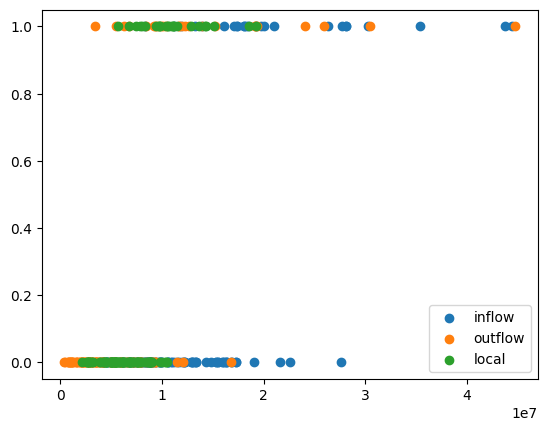

In [77]:
for col in annualpredictor.columns:
    plt.scatter(annualpredictor[col], outdf['BMF_R1'], label = col)

plt.legend()

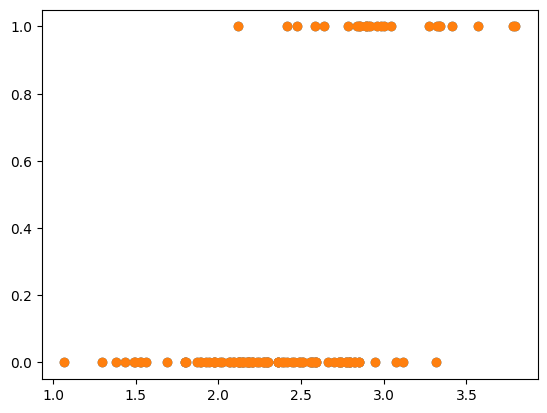

In [78]:
data = pd.concat([annualpredictor['inflow'],outdf['BMF_R1']],axis=1, join='inner')
data['inflow'] = np.log(data['inflow']/1000000)

data = data.reset_index()[data.columns[-2:]]

plt.scatter(x=data['inflow'], y= data['BMF_R1'])

data = data.sort_values(by = 'inflow')

plt.scatter(x=data['inflow'], y= data['BMF_R1'])

Add.0 p


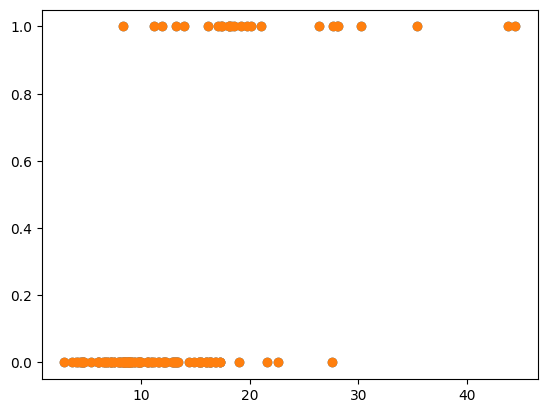

In [99]:
data = pd.concat([annualpredictor['inflow'],outdf['BMF_R1']],axis=1, join='inner')
data['inflow'] = (data['inflow']/1000000)

data = data.reset_index()[data.columns[-2:]]

plt.scatter(x=data['inflow'], y= data['BMF_R1'])

data = data.sort_values(by = 'inflow')
n = 1 #data.shape[0]

plt.scatter(data['inflow'], data['BMF_R1'], label = col)

with pymc.Model() as binomial_regression_model:
    x = pymc.Data("x", (data['inflow']))
    # priors
    beta0 = pymc.Normal("beta0", mu=0, sigma=100)
    beta1 = pymc.Normal("beta1", mu=0, sigma=100)
    # linear model
    mu = beta0 + beta1 * x
    p = pymc.Deterministic("p", pymc.math.invlogit(mu))
    print(mu, p)
    # likelihood
    pymc.Binomial("y", n=n, p=p, observed=data['BMF_R1'])

In [100]:
with binomial_regression_model:
    idata = pymc.sample(2000, tune=4000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1]


Output()

Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 39 seconds.


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>]], dtype=object)

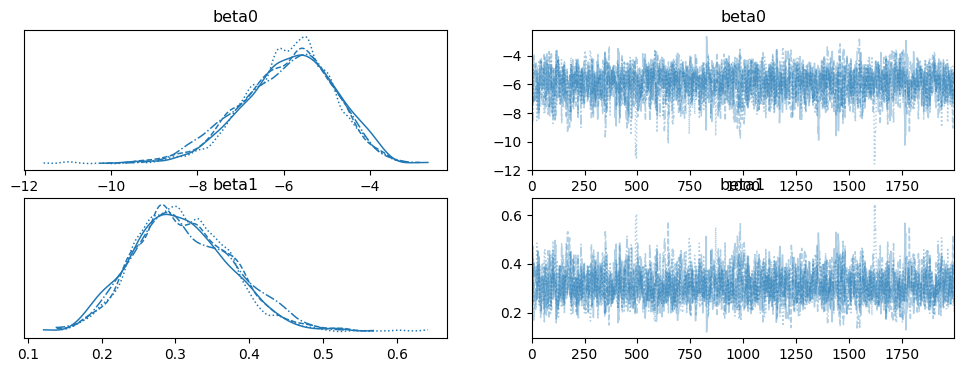

In [101]:
az.plot_trace(idata, var_names=["beta0", "beta1"])

In [102]:
p_true = (data["BMF_R1"])

C:\Users\rob635\AppData\Local\Temp\ipykernel_9700\3137675337.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(facecolor="white", frameon=True);


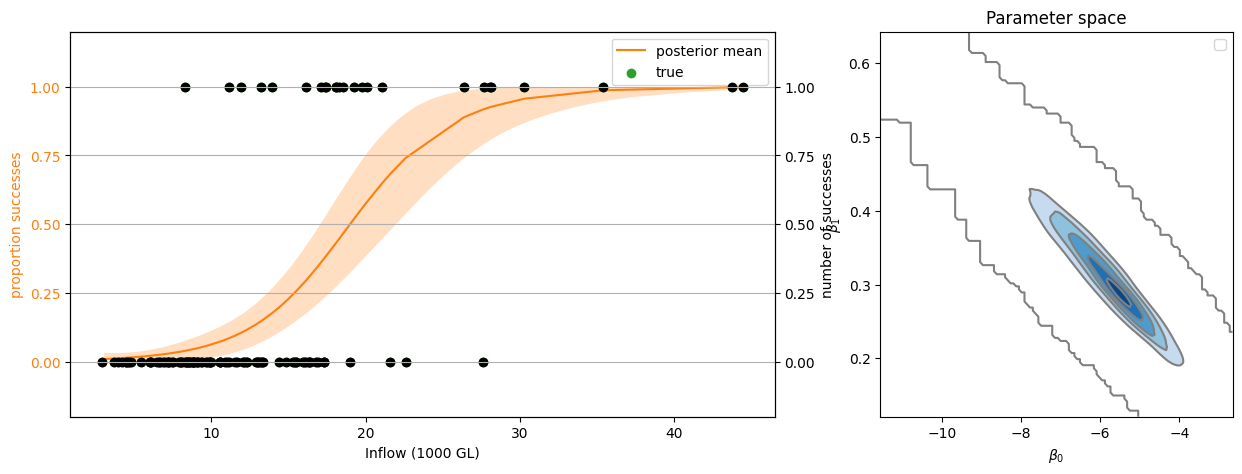

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["inflow"],
    idata.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = idata.posterior.p.mean(("chain", "draw"))
ax[0].plot(data["inflow"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].scatter(data["inflow"], p_true,  label="true", color="C2")
# formatting
ax[0].set(xlabel="Inflow (1000 GL)")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
#ax[0].set_xscale('log')
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of successes")
freq.scatter(data["inflow"], data["BMF_R1"], color="k", label="data")
# get y-axes to line up
y_buffer = 0.2
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, n, 5) / n)
freq.set(yticks=np.linspace(0, n, 5))

# Parameter space plot ===================================================
az.plot_kde(
    az.extract(idata, var_names="beta0"),
    az.extract(idata, var_names="beta1"),
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
#ax[1].plot(beta0_true, beta1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);

In [114]:
predictdata1 = data.copy(deep=True)
predictdata2 = data.copy(deep = True)
predictdata1 = predictdata1[0:100]
predictdata2 = predictdata2[0:100]
predictdata1['inflow'] = np.exp(np.log(data['inflow'].min() )+np.array([float(a)/float(100.) for a in range(100)] )* (np.log(data['inflow'].max())-np.log(data['inflow'].min())))
predictdata2['inflow'] = np.exp(np.log(data['inflow'].min() )+np.array([float(a)/float(100.) for a in range(100)] )* (np.log(data['inflow'].max())-np.log(data['inflow'].min())))

In [105]:
predictdata1.drop(columns=['BMF_R1'],inplace=True)

In [115]:
with binomial_regression_model:
    pymc.set_data({'x':predictdata1['inflow'] })
    idata1 = pymc.sample_posterior_predictive(idata,  var_names="p")

    pymc.set_data({'x':predictdata2['inflow']})
    idata2 = pymc.sample_posterior_predictive(idata, var_names="p")

Sampling: []


Output()

Sampling: []


Output()

In [107]:
with binomial_regression_model:
    pymc.set_data({'x':predictdata2['inflow'] })
    idata = pymc.sample_posterior_predictive(idata,  var_names=["p"],
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True,)

Sampling: []


Output()

In [116]:
outquants1 = idata1.posterior_predictive.p.quantile(q= [0.025,0.25,0.5,0.75,0.975], dim = ("chain",'draw') )
outquants2 = idata2.posterior_predictive.p.quantile(q= [0.025,0.25,0.5,0.75,0.975], dim = ("chain",'draw') )

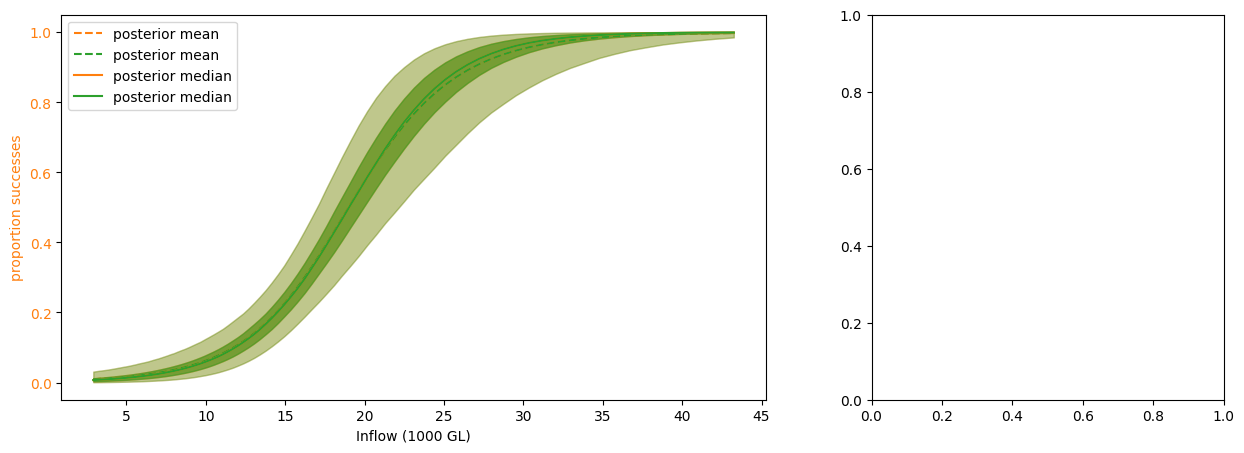

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={"width_ratios": [2, 1]})

ax[0].fill_between(x = (predictdata1['inflow']), y1 = outquants1.loc[{'quantile':0.025}].data ,y2 = outquants1.loc[{'quantile':0.975}].data, color = "C1", alpha = 0.3)
ax[0].fill_between(x = (predictdata2['inflow']), y1 = outquants2.loc[{'quantile':0.025}].data ,y2 = outquants2.loc[{'quantile':0.975}].data, color = "C2", alpha = 0.3)
ax[0].fill_between(x = (predictdata1['inflow']), y1 = outquants1.loc[{'quantile':0.25}].data ,y2 = outquants1.loc[{'quantile':0.75}].data, color = "C1", alpha = 0.6)
ax[0].fill_between(x = (predictdata2['inflow']), y1 = outquants2.loc[{'quantile':0.25}].data ,y2 = outquants2.loc[{'quantile':0.75}].data, color = "C2", alpha = 0.6)

# posterior mean
post_mean1 = idata1.posterior_predictive.p.mean(("chain", "draw"))
post_mean2 = idata2.posterior_predictive.p.mean(("chain", "draw"))
ax[0].plot(predictdata1["inflow"], post_mean1, label="posterior mean", color="C1", linestyle = "--")
ax[0].plot(predictdata2["inflow"], post_mean2, label="posterior mean", color="C2", linestyle = "--")

ax[0].plot(predictdata1["inflow"], outquants1.loc[{'quantile':0.5}].data, label="posterior median", color="C1")
ax[0].plot(predictdata2["inflow"], outquants2.loc[{'quantile':0.5}].data, label="posterior median", color="C2")

# plot truth
#ax[0].scatter(data["inflow"], p_true,  label="true", color="C2")
# formatting
ax[0].set(xlabel="Inflow (1000 GL)")
#ax[0].set_xscale('log')
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()

In [ ]:
laggedinflow_predictor

In [ ]:
data = pd.concat([annualpredictor['inflow'], laggedinflow_predictor['inflow_lagged'],outdf['BMF_R1']],axis=1, join='inner')
data

In [ ]:
data.head()

               inflow  inflow_lagged  BMF_R1
1896-06-30  8322251.0      6021355.0     1.0
1897-06-30  6021355.0      8828884.0     0.0
1898-06-30  8828884.0      8595550.0     0.0
1899-06-30  8595550.0      8050405.0     0.0
1900-06-30  8050405.0     10863476.0     0.0
...               ...            ...     ...
2004-06-30  9055549.0      7253731.0     0.0
2005-06-30  7253731.0      8887863.0     0.0
2006-06-30  8887863.0      2910648.0     0.0
2007-06-30  2910648.0      4761189.0     0.0
2008-06-30  4761189.0      3659820.0     0.0

[113 rows x 3 columns]
Add.0 p


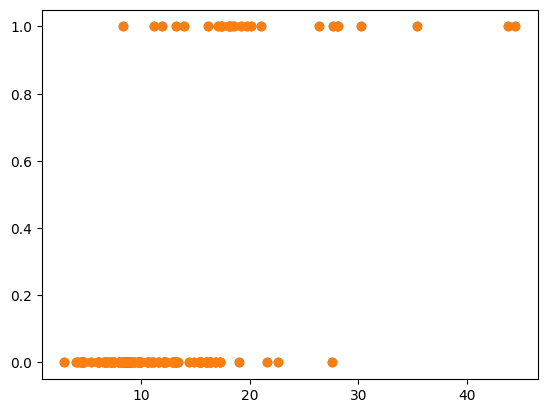

In [120]:

data = pd.concat([annualpredictor['inflow'], laggedinflow_predictor['inflow_lagged'],outdf['BMF_R1']],axis=1, join='inner')

#data = pd.concat([data ,outdf['BMF_R1']],axis=1, join='inner')
print(data)
data['inflow'] = (data['inflow']/1000000)
data['inflow_lagged'] = (data['inflow_lagged']/1000000)
data = data.reset_index()[data.columns[-3:]]

plt.scatter(x=data['inflow'], y= data['BMF_R1'])

data = data.sort_values(by = 'inflow')
n = 1 #data.shape[0]

plt.scatter(data['inflow'], data['BMF_R1'], label = col)

with pymc.Model() as binomial_regression_model:
    x = pymc.Data("x", (data['inflow']))
    z = pymc.Data("z", (data['inflow_lagged']))
    # priors
    beta0 = pymc.Normal("beta0", mu=0, sigma=100)
    beta1 = pymc.Normal("beta1", mu=0, sigma=100)
    beta2 = pymc.Normal("beta2", mu=0, sigma=100)
    # linear model
    mu = beta0 + beta1 * x + beta2 * z
    p = pymc.Deterministic("p", pymc.math.invlogit(mu))
    print(mu, p)
    # likelihood
    pymc.Binomial("y", n=n, p=p, observed=data['BMF_R1'])

In [121]:
with binomial_regression_model:
    idata = pymc.sample(2000, tune=4000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2]


Output()

Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 67 seconds.


array([[<Axes: title={'center': 'beta0'}>,
        <Axes: title={'center': 'beta0'}>],
       [<Axes: title={'center': 'beta1'}>,
        <Axes: title={'center': 'beta1'}>],
       [<Axes: title={'center': 'beta2'}>,
        <Axes: title={'center': 'beta2'}>]], dtype=object)

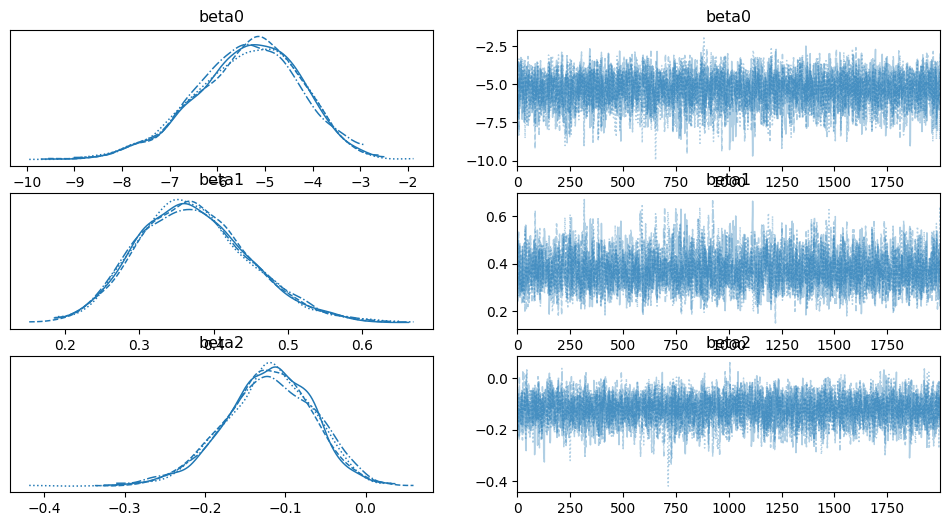

In [122]:
az.plot_trace(idata, var_names=["beta0", "beta1", "beta2"])

C:\Users\rob635\AppData\Local\Temp\ipykernel_9700\740328428.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend(facecolor="white", frameon=True);


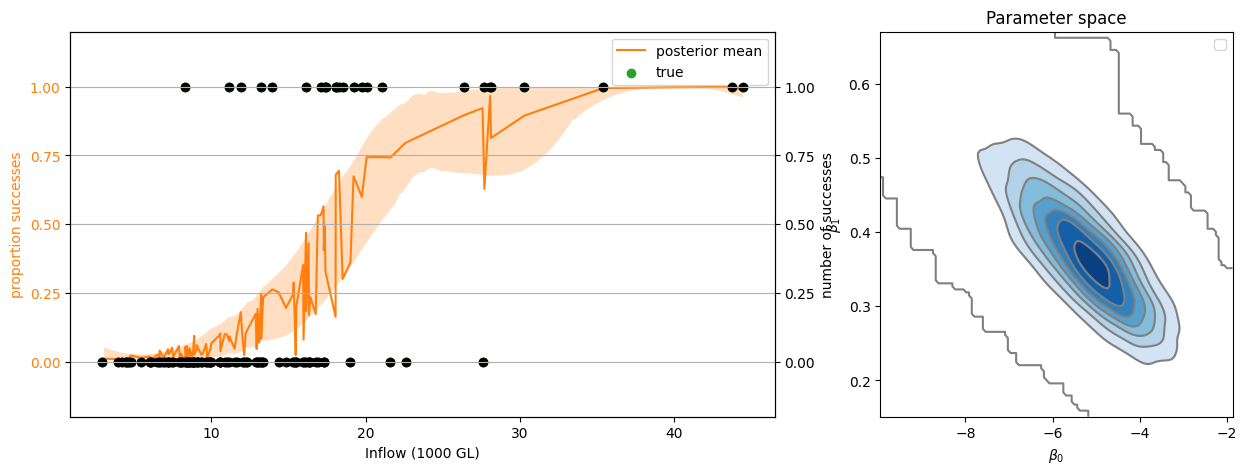

In [123]:
p_true = (data["BMF_R1"])
fig, ax = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    data["inflow"],
    idata.posterior.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = idata.posterior.p.mean(("chain", "draw"))
ax[0].plot(data["inflow"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].scatter(data["inflow"], p_true,  label="true", color="C2")
# formatting
ax[0].set(xlabel="Inflow (1000 GL)")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
#ax[0].set_xscale('log')
# instantiate a second axes that shares the same x-axis
freq = ax[0].twinx()
freq.set_ylabel("number of successes")
freq.scatter(data["inflow"], data["BMF_R1"], color="k", label="data")
# get y-axes to line up
y_buffer = 0.2
freq.set(ylim=[-y_buffer, n + y_buffer])
ax[0].set(ylim=[-(y_buffer / n), 1 + (y_buffer / n)])
freq.grid(None)
# set both y-axis to have 5 ticks
ax[0].set(yticks=np.linspace(0, n, 5) / n)
freq.set(yticks=np.linspace(0, n, 5))

# Parameter space plot ===================================================
az.plot_kde(
    az.extract(idata, var_names="beta0"),
    az.extract(idata, var_names="beta1"),
    contourf_kwargs={"cmap": "Blues"},
    ax=ax[1],
)
#ax[1].plot(beta0_true, beta1_true, "C2o", label="true")
ax[1].set(xlabel=r"$\beta_0$", ylabel=r"$\beta_1$", title="Parameter space")
ax[1].legend(facecolor="white", frameon=True);

In [132]:
predictdata1 = data.copy(deep=True)
predictdata2 = data.copy(deep = True)
predictdata1['inflow_lagged'] = data['inflow_lagged'].quantile([0.01]).values[0]
predictdata2['inflow_lagged'] = data['inflow_lagged'].quantile([0.99]).values[0]
predictdata1['inflow'] = np.exp(np.log(data['inflow'].min() )+np.array([float(a)/float(data.shape[0]) for a in range(data.shape[0])] )* (np.log(data['inflow'].max())-np.log(data['inflow'].min())))

predictdata2['inflow'] = np.exp(np.log(data['inflow'].min() )+np.array([float(a)/float(data.shape[0]) for a in range(data.shape[0])] )* (np.log(data['inflow'].max())-np.log(data['inflow'].min())))

In [133]:
with binomial_regression_model:
    pymc.set_data({'x':predictdata1['inflow'], 'z':predictdata1['inflow_lagged']})
    idata1 = pymc.sample_posterior_predictive(idata,  var_names="p")

    pymc.set_data({'x':predictdata2['inflow'], 'z':predictdata2['inflow_lagged']})
    idata2 = pymc.sample_posterior_predictive(idata, var_names="p")

Sampling: []


Output()

Sampling: []


Output()

In [137]:
outquants1 = idata1.posterior_predictive.p.quantile(q= [0.05,0.25,0.5,0.75,0.95], dim = ("chain",'draw') )
outquants2 = idata2.posterior_predictive.p.quantile(q= [0.05,0.25,0.5,0.75,0.95], dim = ("chain",'draw') )

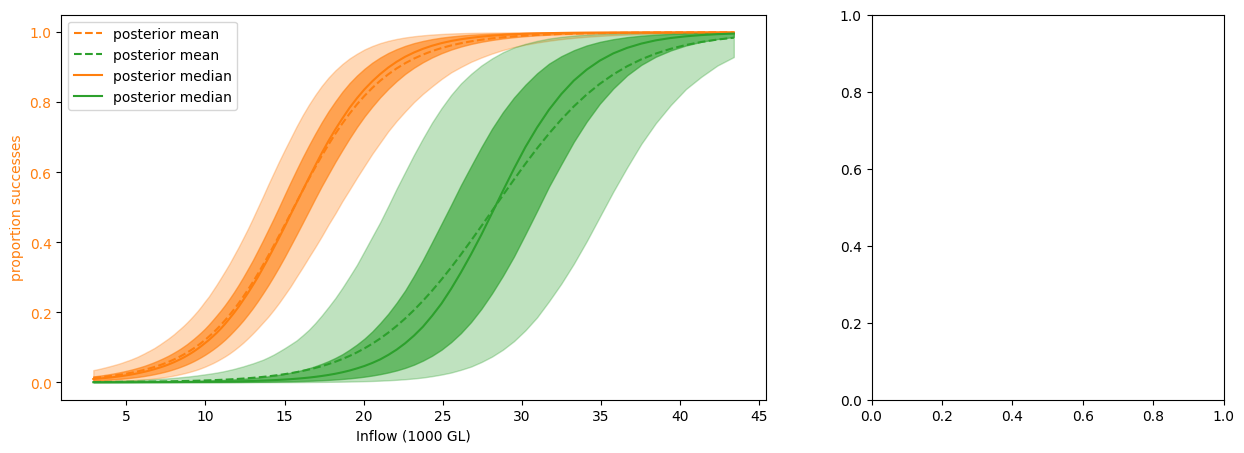

In [138]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={"width_ratios": [2, 1]})

ax[0].fill_between(x = (predictdata1['inflow']), y1 = outquants1.loc[{'quantile':0.05}].data ,y2 = outquants1.loc[{'quantile':0.95}].data, color = "C1", alpha = 0.3)
ax[0].fill_between(x = (predictdata2['inflow']), y1 = outquants2.loc[{'quantile':0.05}].data ,y2 = outquants2.loc[{'quantile':0.95}].data, color = "C2", alpha = 0.3)
ax[0].fill_between(x = (predictdata1['inflow']), y1 = outquants1.loc[{'quantile':0.25}].data ,y2 = outquants1.loc[{'quantile':0.75}].data, color = "C1", alpha = 0.6)
ax[0].fill_between(x = (predictdata2['inflow']), y1 = outquants2.loc[{'quantile':0.25}].data ,y2 = outquants2.loc[{'quantile':0.75}].data, color = "C2", alpha = 0.6)

# posterior mean
post_mean1 = idata1.posterior_predictive.p.mean(("chain", "draw"))
post_mean2 = idata2.posterior_predictive.p.mean(("chain", "draw"))
ax[0].plot(predictdata1["inflow"], post_mean1, label="posterior mean", color="C1", linestyle = "--")
ax[0].plot(predictdata2["inflow"], post_mean2, label="posterior mean", color="C2", linestyle = "--")

ax[0].plot(predictdata1["inflow"], outquants1.loc[{'quantile':0.5}].data, label="posterior median", color="C1")
ax[0].plot(predictdata2["inflow"], outquants2.loc[{'quantile':0.5}].data, label="posterior median", color="C2")

# plot truth
#ax[0].scatter(data["inflow"], p_true,  label="true", color="C2")
# formatting
ax[0].set(xlabel="Inflow (1000 GL)")

ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()

In [ ]:
p_true = (data["BMF_R1"])
fig, ax = plt.subplots(1, 2, figsize=(15,5), gridspec_kw={"width_ratios": [2, 1]})

# Data space plot ========================================================
az.plot_hdi(
    predictdata2["inflow"],
    idata2.posterior_predictive.p,
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.25, "linewidth": 0},
    ax=ax[0],
    color="C1",
)
# posterior mean
post_mean = idata2.posterior_predictive.p.mean(("chain", "draw"))
ax[0].plot(predictdata2["inflow"], post_mean, label="posterior mean", color="C1")
# plot truth
ax[0].scatter(predictdata2["inflow"], p_true,  label="true", color="C2")
# formatting
ax[0].set(xlabel="Inflow (1000 GL)")
ax[0].set_ylabel("proportion successes", color="C1")
ax[0].tick_params(axis="y", labelcolor="C1")
ax[0].legend()
